In [1]:
from __future__ import print_function

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import (precision_recall_curve, auc,average_precision_score,
                             roc_curve,precision_score, recall_score,  f1_score)
import statsmodels.api as sm
from utils.plot_culve import plot_ROC,plot_PRC
import time
from load_data.tabular import load_tab_data
import models 
#import torch.utils.data

In [2]:
def reparameterize_Ltimes(mu, logvar,L):
    std = torch.exp(0.5*logvar)
    std = std.unsqueeze(1).repeat(1,L, 1)
    mu = mu.unsqueeze(1).repeat(1,L, 1)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)

In [10]:
def trainset_anomaly_score(x_train,encoder,decoder):
    print('computing anomaly score in training dataset...')
    encoder.eval()
    decoder.eval()
    L=1000
    #x_recon_error=torch.FloatTensor(x_train.size()[0]).zero_()
    with torch.no_grad():
        mu_train, logvar_train=encoder(x_train)
        z_train=reparameterize_Ltimes(mu_train, logvar_train,L)
        x_recon=decoder(z_train)
        res=x_recon-x_train.unsqueeze(1).repeat(1,L,1)
        res=torch.mean(res, 1, keepdim=False)
        spe=torch.diag(torch.mm(res,torch.transpose(res, 0, 1)))
    return spe.cpu().numpy()

In [11]:
def testset_anomaly_score(x_test,encoder,decoder):
    print('computing anomaly score in testing dataset...')
    encoder.eval()
    decoder.eval()
    L=1000
    with torch.no_grad():
        mu_test, logvar_test=encoder(x_test)
        z_test=reparameterize_Ltimes(mu_test, logvar_test,L)       
        x_recon=decoder(z_test)
        res=x_recon-x_test.unsqueeze(1).repeat(1,L,1)
        res=torch.mean(res, 1, keepdim=False)
        spe=torch.diag(torch.mm(res,torch.transpose(res, 0, 1)))
    return spe.cpu().numpy()

In [6]:
def learning_threshold(train_recon_error,alpha):
    dens = sm.nonparametric.KDEUnivariate(train_recon_error.astype(np.float))
    bound = np.linspace(min(train_recon_error),max(train_recon_error),1024)
    dens.fit(bw='silverman',gridsize=1024)
    threshold=bound[min(np.where(dens.cdf>alpha)[0])]
    return threshold

In [19]:
def show_pre_recall_f1(test_recon_error,test_label,threshold):
    y_pred=test_recon_error.copy()
    larger_idx=np.where(y_pred>=threshold)
    lower_idx=np.where(y_pred<threshold)
    y_pred[lower_idx[0]]=0
    y_pred[larger_idx[0]]=1
    print('precision:',precision_score(test_label,y_pred))
    print('recall:',recall_score(test_label,y_pred))
    print('f1 score:',f1_score(test_label,y_pred))

In [20]:
def show_results(dataset_name):
    data_path='./datasets/'
    save_path='D:/GitHub/selfADVAE-AD/checkpoints'
    device='cuda'
    batch_size=32
    n_jobs_dataloader=0
    
    #load_dataset
    train_data,train_label,test_data,test_label,sample_dim,rep_dim=load_tab_data(data_path=data_path, dataset_name=dataset_name)
    scaler=MinMaxScaler().fit(train_data)
    train_data_scaled=scaler.transform(train_data) 
    test_data_scaled=scaler.transform(test_data) 
    x_train=torch.cuda.FloatTensor(train_data_scaled)
    x_test=torch.cuda.FloatTensor(test_data_scaled)
    
    # build model
    encoder = models.Encoder(sample_dim=sample_dim,rep_dim=rep_dim).to(device)
    decoder = models.Decoder(sample_dim=sample_dim,rep_dim=rep_dim).to(device)
    
    #load a well-trained adVAE model
    net_name=dataset_name+'selfADVAE' 
    encoder.load(save_path+'/'+net_name+'encoder')
    decoder.load(save_path+'/'+net_name+'decoder')
    
    #computing anomaly score
    train_recon_error=trainset_anomaly_score(x_train,encoder,decoder)
    start_time = time.time()
    test_recon_error=testset_anomaly_score(x_test,encoder,decoder)
    train_time = time.time() - start_time
    print('testing time: %.3f' % train_time)
    
    #learning_threshold
    threshold=learning_threshold(train_recon_error,0.9)
    print('threshold',threshold)
    
    show_pre_recall_f1(test_recon_error,test_label,threshold)
    
    # plot PRC and ROC
    plot_PRC(test_label, test_recon_error)
    plot_ROC(test_label, test_recon_error)

C:\Users\33\AppData\Local\conda\conda\envs\wxhdl\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


computing anomaly score in training dataset...
computing anomaly score in testing dataset...
testing time: 0.014
threshold 0.6604945363580657
precision: 0.46107784431137727
recall: 0.77
f1 score: 0.5767790262172285


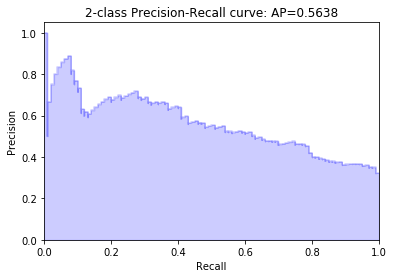

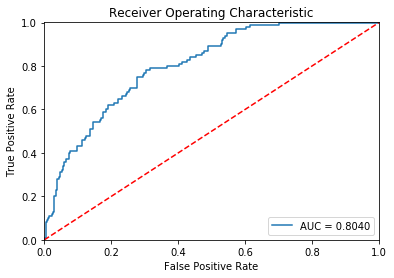

In [26]:
show_results(dataset_name='letter')

computing anomaly score in training dataset...
computing anomaly score in testing dataset...
testing time: 0.013
threshold 0.49615111257352906
precision: 0.7051282051282052
recall: 0.9375
f1 score: 0.8048780487804879


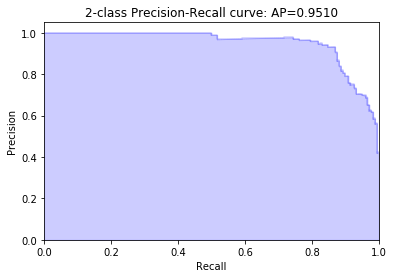

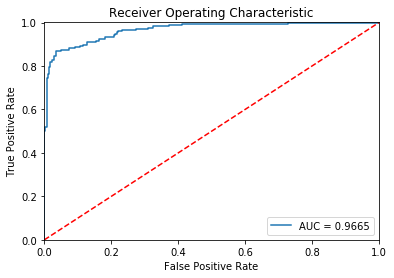

In [23]:
show_results(dataset_name='cardio')

C:\Users\33\AppData\Local\conda\conda\envs\wxhdl\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


computing anomaly score in training dataset...
computing anomaly score in testing dataset...
testing time: 0.042
threshold 0.1570420017427713
precision: 0.5
recall: 0.8533333333333334
f1 score: 0.6305418719211823


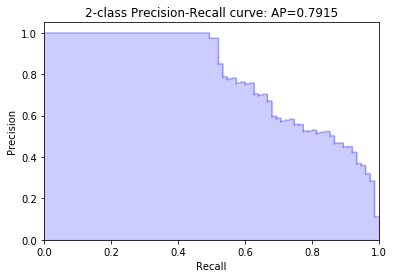

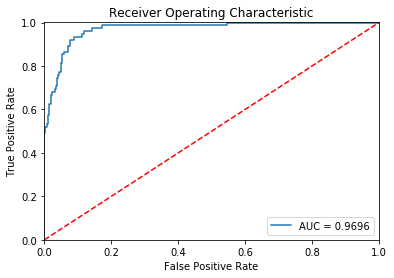

In [24]:
show_results(dataset_name='satellite')

computing anomaly score in training dataset...
computing anomaly score in testing dataset...
testing time: 0.053
threshold 1.3469331920846117
precision: 0.5928853754940712
recall: 1.0
f1 score: 0.7444168734491314


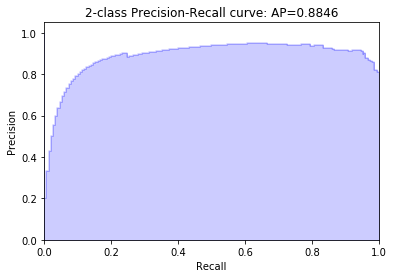

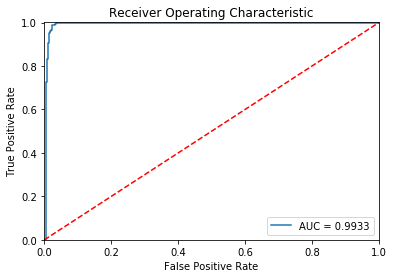

In [25]:
show_results(dataset_name='optdigits')

computing anomaly score in training dataset...
computing anomaly score in testing dataset...
testing time: 0.029
threshold 0.4767013496700183
precision: 0.5473684210526316
recall: 1.0
f1 score: 0.707482993197279


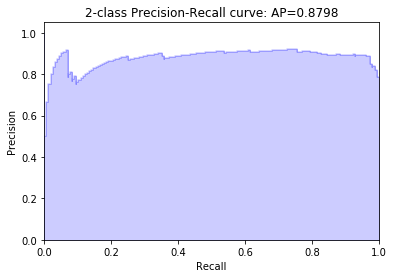

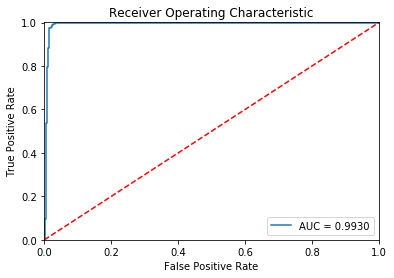

In [21]:
show_results(dataset_name='pendigits')